In [1]:
import pandas as pd
import numpy as np
import os

import google_auth_oauthlib.flow
import googleapiclient.discovery
import googleapiclient.errors
import pickle
import matplotlib.pyplot as plt

In [2]:
folder = "D:\HousieProject\ytanalytics\Takeout\YouTube and YouTube Music\history"

def initial_process():
    
    df = pd.read_json(folder+"\watch-history.json")
    df = df.drop(columns=['header', 'subtitles','products','activityControls','details','description'])
    df = df[df['titleUrl'].notna()]
    df['videoId'] = df['titleUrl'].str.extract(r'v=(.*)')
    df.to_json(folder+"\processed_data_1.json", orient='records')
    #display(df)

# initial_process()

def read_ini_proc():
    df= pd.read_json(folder+"\processed_data_1.json")
    df.set_index('videoId', inplace=True)
    return df

df = read_ini_proc()

# df = df.head(100)
# df
    

In [3]:
os.environ["OAUTHLIB_INSECURE_TRANSPORT"] = "1"
client_secrets_file = "client_secret_792466442882.json"
def get_authenticated_service():
    if os.path.exists("CREDENTIALS_PICKLE_FILE"):
        with open("CREDENTIALS_PICKLE_FILE", 'rb') as f:
            credentials = pickle.load(f)
    else:
        flow = google_auth_oauthlib.flow.InstalledAppFlow.from_client_secrets_file(client_secrets_file, ["https://www.googleapis.com/auth/youtube.readonly"])
        credentials = flow.run_console()
        with open("CREDENTIALS_PICKLE_FILE", 'wb') as f:
            pickle.dump(credentials, f)
    return googleapiclient.discovery.build("youtube", "v3", credentials=credentials)


def batch(iterable, n=1):
    l = len(iterable)
    for ndx in range(0, l, n):
        yield iterable[ndx:min(ndx + n, l)]


In [4]:


def get_category_tags_from_ytAPI(df):
    df["categoryId"]=""
    df["tags"] = np.empty((len(df), 0)).tolist()
    allIdsfromDF = [x for x in df.index.tolist() if x is not None]
    # print(allIdsfromDF)
    display(df)
    # Get credentials and create an API client
    flow = google_auth_oauthlib.flow.InstalledAppFlow.from_client_secrets_file(client_secrets_file, ["https://www.googleapis.com/auth/youtube.readonly"])
    youtube = get_authenticated_service()
    progress=0;
    for x in batch(allIdsfromDF, 50):
        idList=",".join(x)
        progress+=len(x);
        print("progress: {}/{}".format(progress,len(df.index)))

        request = youtube.videos().list(
            part="snippet",
            id=idList
        )
        response = request.execute()
        
        items = response["items"]
        # print(response)
        for item in items:
            id = str(item["id"])
            snippet = item["snippet"]
            categoryId = str(snippet.get("categoryId","-1"))
            print("{},{}".format(id,categoryId))
            df.at[id,'categoryId']=categoryId
            try:
                tags=snippet.get('tags')
                df.at[id,'tags'].append(tags)
                print("{},{}".format(id,tags))
            except:
                print("An exception occurred")
            
            
    return df


# get_category_tags_from_ytAPI(df)
# df.to_json(folder+"\processed_data_2.json", orient='records')




In [5]:
df = pd.read_json(folder+"\processed_data_2.json")
df = df[['titleUrl', 'time', 'categoryId']].copy()
df = df[df['categoryId'].astype(bool)]
# display(df)
catList = df['categoryId'].unique()
# print(catList)

def getCategoryLabels(df):
    flow = google_auth_oauthlib.flow.InstalledAppFlow.from_client_secrets_file(client_secrets_file, ["https://www.googleapis.com/auth/youtube.readonly"])
    youtube = get_authenticated_service()
    idL = ",".join(catList)
    request = youtube.videoCategories().list(
            part="snippet",
            id=idL
    )
    response = request.execute()
    items = response["items"]
    dic={}
    for item in items:
        snippet = item["snippet"]
        id = item["id"]
        catName = snippet["title"]
        #print("{},{}".format(id,catName))
        dic[id] = catName
    return dic
        
dic = getCategoryLabels(df)
print(dic)

df['catName'] = df['categoryId'].map(dic)
df.to_json(folder+"\processed_data_3.json", orient='records')

{'1': 'Film & Animation', '2': 'Autos & Vehicles', '10': 'Music', '15': 'Pets & Animals', '17': 'Sports', '19': 'Travel & Events', '20': 'Gaming', '22': 'People & Blogs', '23': 'Comedy', '24': 'Entertainment', '25': 'News & Politics', '26': 'Howto & Style', '27': 'Education', '28': 'Science & Technology', '29': 'Nonprofits & Activism', '30': 'Movies', '44': 'Trailers'}


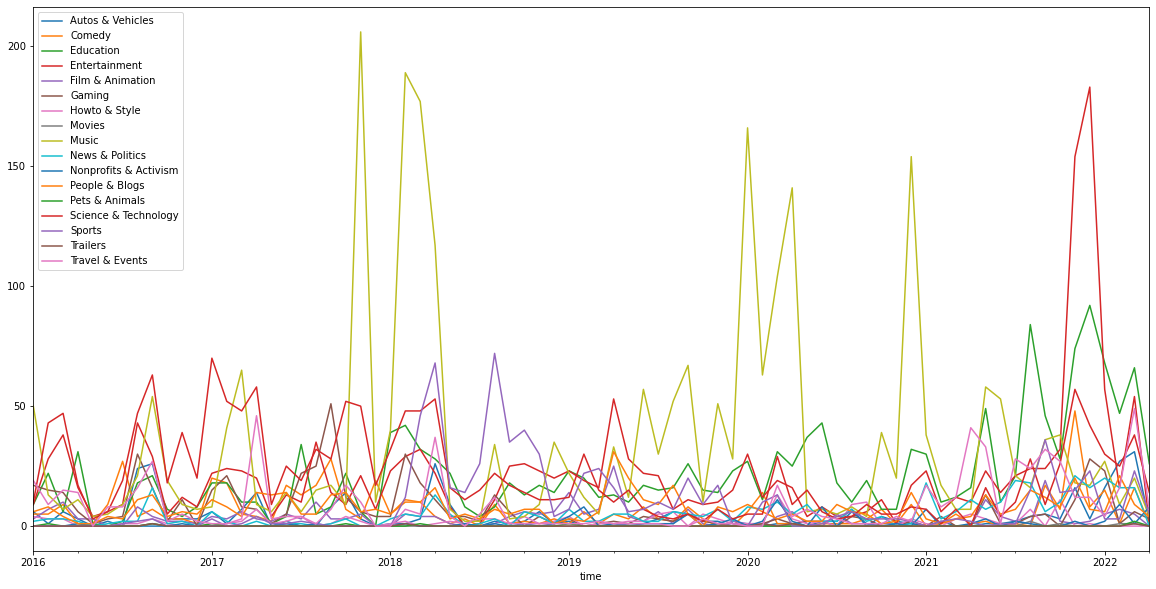

In [7]:
df = pd.read_json(folder+"\processed_data_3.json")
df = df[['time', 'catName']].copy()
df = pd.concat([df, pd.get_dummies(df.catName)], axis=1)


# hue = df.groupby(["catName"]).count()

# display(df)
df.index = pd.to_datetime(df['time'])
hue = df.groupby(pd.Grouper(freq='M')).sum()
# display(hue)

# plt.close("all")
hue.plot(figsize=(20,10))
plt.savefig('foo.png')